In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
              
import numpy as np
import jax.numpy as jnp
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
import yt
from yt.visualization.volume_rendering.api import Scene, Camera, TransferFunctionHelper, create_volume_source, LineSource

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import seaborn as sns

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['savefig.bbox'] = 'tight'

columnwidth = 246
textwidth = 510
inches_per_pt = 1 / 72.27
figwidth = columnwidth * inches_per_pt

In [3]:
import jaxsp as jsp
import s2fft

In [4]:
def latex_float(f):
    if f==0.0:
        return "0.0"
    float_str = "{0:.1e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(round(float(base)), int(exponent))
    else:
        return float_str

In [5]:
init_density = jax.vmap(jsp.init_core_NFW_tides_params_from_sample)
init_potential_params = jax.vmap(jsp.init_potential_params, in_axes=(0, 0, 0, None))
rho = jax.vmap(jsp.rho, in_axes=(0,None))
rho_psi = jax.vmap(jsp.rho_psi, in_axes=(0,None,None))
rhos = jax.vmap(rho, in_axes=(None,0))
eval_library = jax.vmap(jax.vmap(jsp.eval_radial_eigenmode, in_axes=(None, 0)), in_axes=(0,None))
enclosing_radius = jax.vmap(jsp.enclosing_radius, in_axes=(None,0))
mass = jax.vmap(jsp.enclosed_mass, in_axes=(0,None))
masses = jax.vmap(mass, in_axes=(None,0))
total_mass = jax.vmap(jsp.total_mass)

In [6]:
gravsphere_chains = "../data/coreNFWtides_parameters/output_M200c200_chain_LeoII.txt"
N_samples = 5000

### Folk Limit for Leo II

In [7]:
u = jsp.set_schroedinger_units(1.0)
chain_data = np.empty((N_samples, 6))
chain_data = np.loadtxt(gravsphere_chains)
chain_data[:, 0] *= u.from_Msun
chain_data[:, 3] *= u.from_Kpc
chain_data[:, 4] *= u.from_Kpc
chain_data = jnp.array(chain_data[:N_samples])

densities_params = init_density(chain_data)
mean_profile_params = jsp.init_core_NFW_tides_params_from_sample(jnp.median(chain_data, axis=0))

r999 = enclosing_radius(0.999, densities_params)
rmin = 1e-4 * u.from_Kpc * jnp.ones_like(r999)
potentials_params = init_potential_params(densities_params, rmin, r999, 256)

In [8]:
from jaxopt import Bisection
from functools import partial

@jax.vmap
def r200(density_params):
    def diff(r):
        return 4*jnp.pi/3 * 200 * 1/jsp.om.value * r**3 - jsp.enclosed_mass(r, density_params)

    bisec = Bisection(optimality_fun=diff, lower=1e-2, upper=1e6, check_bracket=False)
    return bisec.run().params

@jax.vmap
def potential_energy_tensor_trace(density_params, potential_params):
    """
    Binney & Tremaine eq. 2.24
    """
    def dW(r, density_params, potential_params):
        return -4*jnp.pi * r**2 * jsp.potential(r, potential_params) * jsp.rho(r, density_params)
    
    @jax.jit
    @partial(jax.vmap, in_axes=(0,None,None))
    def dW_rescaled(x, density_params, potential_params):
        return dW(x/(1-x), density_params, potential_params) / (1-x)**2
 
    return 1/2 * dW_rescaled(jsp.glx256, density_params, potential_params) @ jsp.glw256

In [9]:
W = potential_energy_tensor_trace(densities_params, potentials_params)
M = total_mass(densities_params)
rvir = r200(densities_params)
vvir = jnp.sqrt(jnp.abs(W)/M)
m_limits = 3/2 * u.from_hbar/(vvir * rvir)

print(f"r_vir = {jnp.mean(rvir) * u.to_Kpc} kpc")
print(f"v_vir = {jnp.mean(vvir) * u.to_kms} km/s")
print(f"M = {jnp.mean(M * u.to_Msun)} Msun")
print(f"m > {jnp.mean(m_limits) * u.to_m22} m22")

r_vir = 9.416779198675586 kpc
v_vir = 14.742409798306952 km/s
M = 107709571.92497739 Msun
m > 0.21452384671356678 m22


In [10]:
rvir = r200(densities_params)
rhalf = 3/4 * 0.015 * rvir
Mhalf = jax.vmap(jsp.enclosed_mass)(rhalf, densities_params)
vvir = jnp.sqrt(2 * jsp.GN.value * u.from_cm**3 * u.from_g**-1 * u.from_s**-2 * Mhalf/(5*rhalf))
m_limits = 3/2 * u.from_hbar/(vvir * rvir)

print(f"r_vir = {jnp.mean(rvir) * u.to_Kpc} kpc")
print(f"v_vir = {jnp.mean(vvir) * u.to_kms} km/s")
print(f"m > {jnp.mean(m_limits) * u.to_m22} m22")

r_vir = 9.416779198675586 kpc
v_vir = 5.050770708714247 km/s
m > 0.6418163982620808 m22


### Figure 1 (gravsphere posterior sapmles)

In [11]:
density_params_dict = {}
wavefunction_params_dict = {}
lib_dict = {}
potential_params_dict = {}
u_dict = {}

for m22 in [2.2, 22]:
    u = jsp.set_schroedinger_units(m22)

    chain_data = np.empty((N_samples, 6))
    chain_data = np.loadtxt(gravsphere_chains)
    chain_data, c = np.unique(chain_data, axis=0, return_counts=True)
    chain_data[:, 0] *= u.from_Msun
    chain_data[:, 3] *= u.from_Kpc
    chain_data[:, 4] *= u.from_Kpc
    chain_data = jnp.array(chain_data[:N_samples])

    mean_profile_params = jnp.median(chain_data, axis=0)
    density_params = jsp.init_core_NFW_tides_params_from_sample(mean_profile_params)

    rmin = 1e-4 * u.from_Kpc
    r99 = jsp.enclosing_radius(0.99, density_params)
    r999 = jsp.enclosing_radius(0.999, density_params)
    potential_params = jsp.init_potential_params(density_params, rmin, r999, 512)

    lib = jsp.init_eigenstate_library(potential_params, rmin, r99, 1024)

    rmin = 20 * u.from_pc
    tol = 1e-7
    wavefunction_params = jsp.init_wavefunction_params_jensen_shannon(lib, density_params, rmin, r99, tol)

    u_dict[m22] = u
    density_params_dict[m22] = density_params
    potential_params_dict[m22] = potential_params
    lib_dict[m22] = lib
    wavefunction_params_dict[m22] = wavefunction_params

In [12]:
m22 = 2.2
u = u_dict[m22]
density_params = density_params_dict[m22]
potential_params = potential_params_dict[m22]
lib = lib_dict[m22]
wavefunction_params = wavefunction_params_dict[m22]

N_samples = 5000
chain_data = np.empty((N_samples, 6))
chain_data = np.loadtxt(gravsphere_chains)
chain_data, c = np.unique(chain_data, axis=0, return_counts=True)
chain_data[:, 0] *= u.from_Msun
chain_data[:, 3] *= u.from_Kpc
chain_data[:, 4] *= u.from_Kpc
chain_data = jnp.array(chain_data[:N_samples])

densities_params = init_density(chain_data)

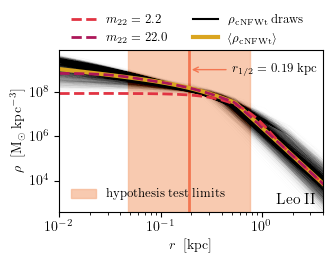

In [13]:
fig, ax = plt.subplots(figsize=(figwidth,0.618*figwidth))
ax.set_xscale("log")
ax.set_yscale("log")
colors = sns.color_palette("rocket_r")

rhalf = 0.19

ax.axvspan(rhalf/4, rhalf*4, color=colors[0], alpha=0.7, label=r"$\mathrm{hypothesis\;test\;limits}$")
ax.axvline(x=rhalf,c=colors[1])
ax.annotate(rf"$r_{{1/2}}={rhalf:.2f}\;\mathrm{{kpc}}$",
            xy=(rhalf, 1e9), 
            xytext=(0.5, 1e9),
            transform=ax.transData, va="center", ha="left", fontsize=9,
            arrowprops=dict(arrowstyle="->", facecolor=colors[1], edgecolor=colors[1]))
ax.text(0.97, 0.05, r"$\mathrm{Leo\;II}$", transform=ax.transAxes, fontsize=11, ha="right")

color = [colors[2], colors[3]]
for m22,c in zip([2.2, 22], color):
    u = u_dict[m22]
    density_params = density_params_dict[m22]
    potential_params = potential_params_dict[m22]
    rmin = 10 * u.from_pc
    rmax = 10 * u.from_Kpc
    r = jnp.logspace(jnp.log10(rmin), jnp.log10(rmax), 256)
    lib = lib_dict[m22]
    if m22==2.2:
        ax.plot(r * u.to_Kpc, rhos(r, densities_params).T * u.to_Msun/u.to_Kpc**3, 
                lw=0.2, alpha=0.02, c="k")
        ax.plot(r * u.to_Kpc, rho(r, density_params) * u.to_Msun/u.to_Kpc**3, 
                lw=3, c="goldenrod", label=r"$\langle\rho_\mathrm{cNFWt}\rangle$")
    wavefunction_params = wavefunction_params_dict[m22]
    ax.plot(r * u.to_Kpc, rho_psi(r, wavefunction_params, lib) * u.to_Msun/u.to_Kpc**3, 
            label=rf"$m_{{22}} = {m22:.1f}$", c=c, lw=2, ls="dashed")
r = jnp.logspace(jnp.log10(wavefunction_params.r_min), jnp.log10(wavefunction_params.r_fit), 256)

ax.plot([1],[1], c="k", label=r"$\rho_\mathrm{cNFWt}\mathrm{\;draws}$", lw=1.5)
l,h, = ax.get_legend_handles_labels()
legend1 = ax.legend(l[:1],h[:1], loc="lower left", fontsize=9)
l = l[1:]
h = h[1:]
l = l[1:] + l[:1]
h = h[1:] + h[:1]
legend2 = ax.legend(l,h, loc="lower left", fontsize=9, bbox_to_anchor=(0, .96), ncol=2)
plt.gca().add_artist(legend1)

ax.set_ylabel(r"$\rho \;\;\mathrm{[M_\odot\;kpc^{-3}]}$")
ax.set_xlabel(r"$r \;\;\mathrm{[kpc]}$")
ax.set_xlim([0.01, 4])
ax.set_ylim([400, 8e9])
plt.show()

### Figure 2 (Volume Rendering)

In [14]:
m22 = 22
u = u_dict[m22]
density_params = density_params_dict[m22]
potential_params = potential_params_dict[m22]
lib = lib_dict[m22]
wavefunction_params = wavefunction_params_dict[m22]

In [15]:
@jax.vmap
def rthetaphi_from(xyz):
    xy = xyz[0]**2 + xyz[1]**2
    r = jnp.sqrt(xy + xyz[2]**2)
    phi = jnp.arctan2(jnp.sqrt(xy), xyz[2]) 
    theta = jnp.arctan2(xyz[1], xyz[0])
    return jnp.array([r,theta,phi])
    
@jax.vmap
def xyz_from(rthetaphi):
    r, theta, phi = rthetaphi[0],rthetaphi[1],rthetaphi[2],
    x = r*jnp.cos(theta) * jnp.sin(phi)
    y = r*jnp.sin(theta) * jnp.sin(phi)
    z = r*jnp.cos(phi)
    return jnp.array([x,y,z])

In [16]:
L = (lib.radial_eigenmode_params.l[-1]+1).item()
nside = L//2
R = 4 * u.from_Kpc #wavefunction_params.r_fit
r = jnp.linspace(wavefunction_params.r_min, R, 512)
theta = s2fft.sampling.s2_samples.thetas(L, sampling="healpix", nside=nside)
phi = [s2fft.sampling.s2_samples.phis_ring(t, nside) for t in range(theta.shape[0])]
phi_len = jnp.array([p.shape[0] for p in phi])
theta = jnp.repeat(theta, phi_len)
phi = jnp.concatenate(phi)
theta_phi = jnp.c_[phi, theta]
psi_new_batch = jax.jit(jax.vmap(jsp.psi, in_axes=(0,None,None,None,None,None)), static_argnums=(3,4))

psi2_healpix = jnp.abs(psi_new_batch(r, wavefunction_params, lib, 
                          lib.radial_eigenmode_params.l[-1].item(), 
                          jnp.max(lib.radial_eigenmode_params.n).item(),
                          jax.random.PRNGKey(42)))**2

In [17]:
N = 256
R = 4 * u.from_Kpc #wavefunction_params.r_fit
dx = 2*R/N
x = y = z = dx * jnp.arange(N) + dx / 2 - R

def cartesian_product(*vecs):
    def cartesian_product(a, b):
        return jax.vmap(
            lambda a, b: jnp.c_[a * jnp.ones(b.shape[0]), b], in_axes=(0, None)
        )(a, b).reshape(-1, a.ndim + b.ndim)

    axb = cartesian_product(vecs[-2], vecs[-1])
    for vec in reversed(vecs[:-2]):
        axb = cartesian_product(vec, axb)
    return axb
xyz = cartesian_product(x,y,z)
rthetaphi = rthetaphi_from(xyz)

In [18]:
xyz_exact = xyz_from(cartesian_product(r, theta_phi))
psi2_interp = NearestNDInterpolator(xyz_exact, psi2_healpix.flatten())
psi2_xyz = psi2_interp(xyz).reshape(N,N,N)

In [19]:
np.save("psi2_220",psi2_xyz)

In [20]:
psi2_xyz = np.load("psi2_220.npy") * u.to_Msun/u.to_Kpc**3
ds = yt.load_uniform_grid(
    dict(density=psi2_xyz),
    [N,N,N],
    bbox=np.array([[-R, R], [-R, R], [-R, R]]) * u.to_Kpc,
    length_unit="kpc",
    mass_unit="Msun"
)

yt : [INFO     ] 2024-05-14 12:19:23,845 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-14 12:19:23,846 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-05-14 12:19:23,846 Parameters: domain_left_edge          = [-4. -4. -4.]
yt : [INFO     ] 2024-05-14 12:19:23,846 Parameters: domain_right_edge         = [4. 4. 4.]
yt : [INFO     ] 2024-05-14 12:19:23,847 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-05-14 12:24:06,632 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-14 12:24:06,640 Creating volume


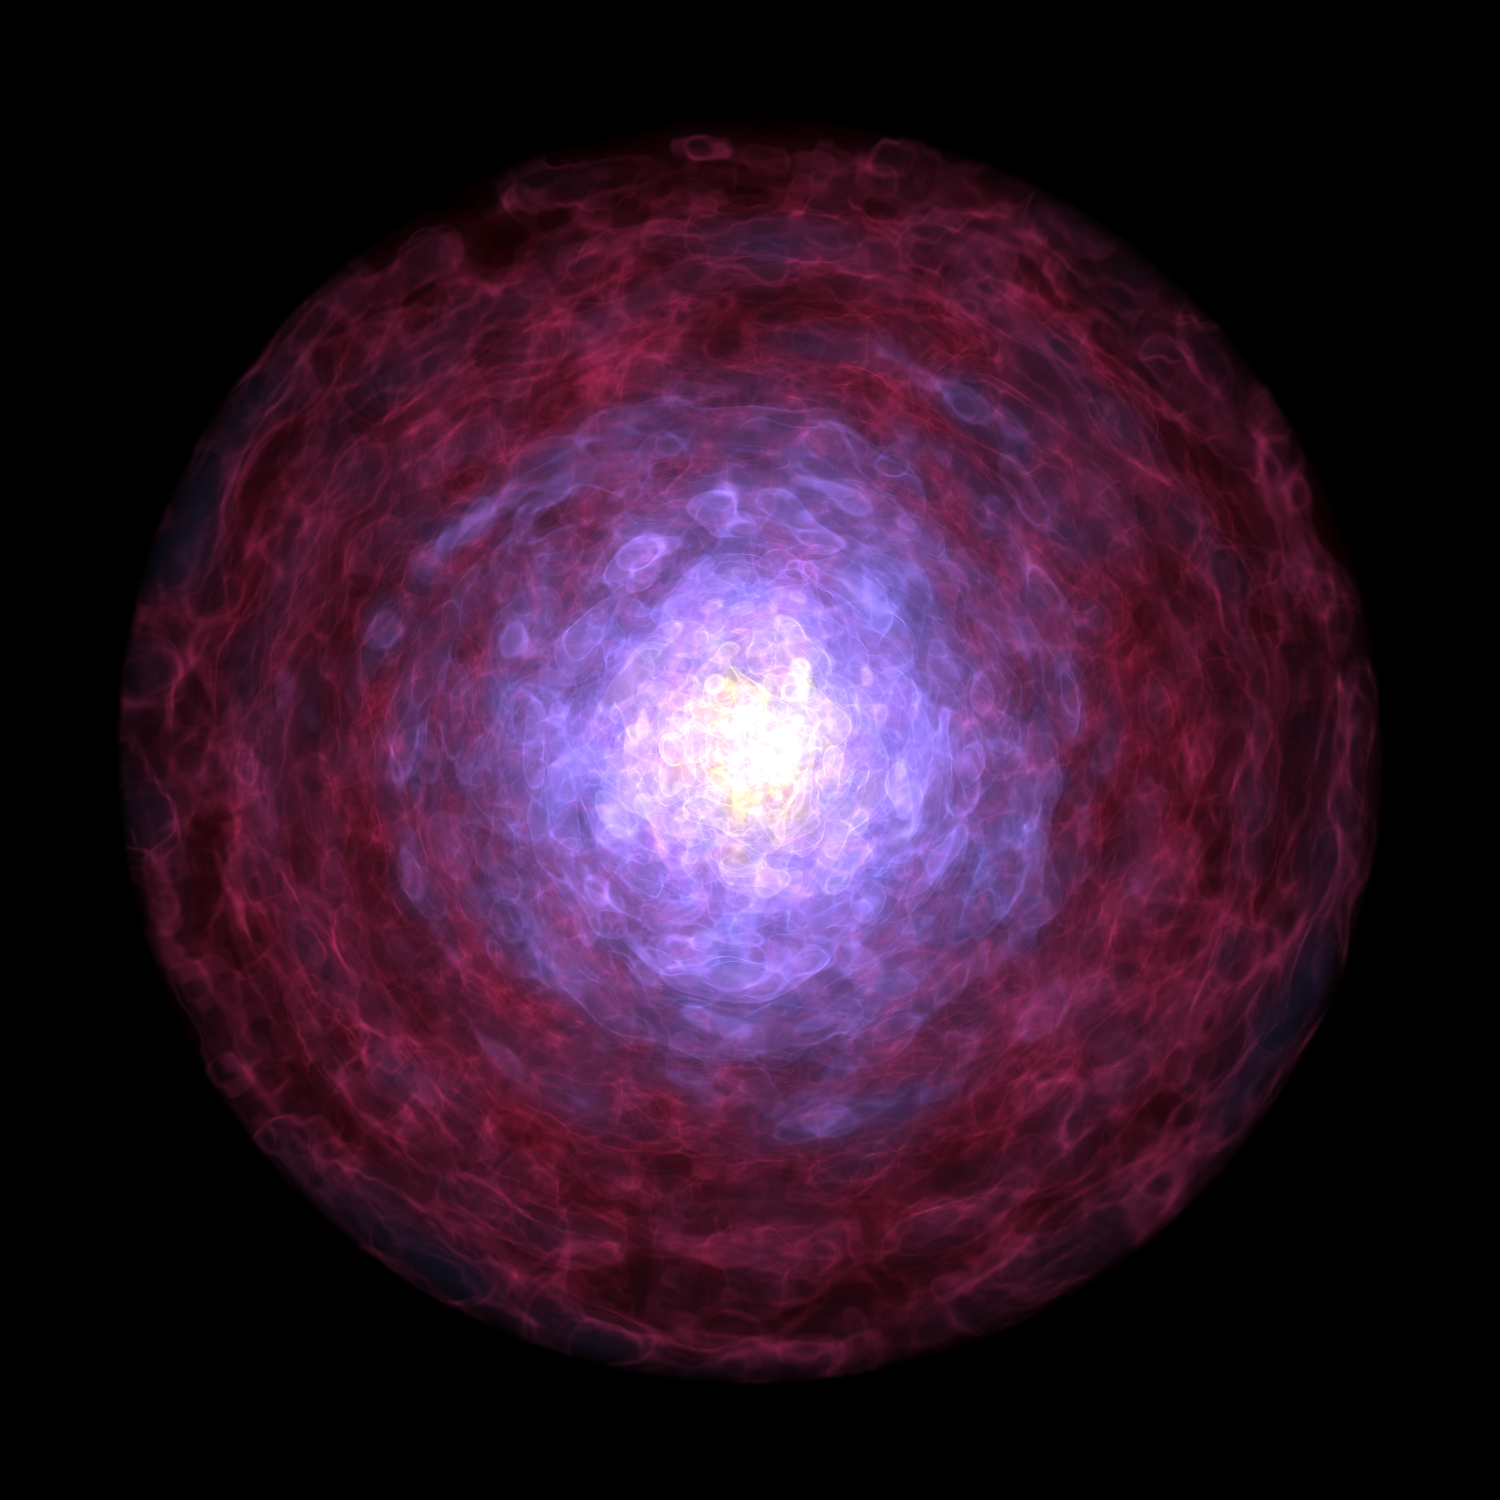

yt : [WARNING  ] 2024-05-14 12:25:36,032 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rendered image directly.
yt : [INFO     ] 2024-05-14 12:25:36,032 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-14 12:27:04,280 Saving rendered image to leoII_0220.png


In [22]:
sc = yt.create_scene(ds.sphere(ds.domain_center,((R * u.to_Kpc).item(),"kpc")), ("stream", "density"), "perspective")
source = sc.get_source()
source.set_log(True)
bounds=(2.5e3,2e9)
    
tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=False)

def quadramp(vals, minval, maxval):
    return ((vals - vals.min()) / (vals.max() - vals.min()))**.5

tf.map_to_colormap(
    np.log10(bounds[0]), np.log10(bounds[1]), 
    colormap="gist_stern", 
    scale_func=quadramp
)
tf.add_layers(8,
              colormap="gist_stern", 
              alpha=np.geomspace(1, 8, 8))

source.tfh.tf = tf
source.tfh.bounds = bounds

camera = sc.camera
camera.position = [1.,1, 1]
camera.resolution = (1500,1500)
camera.zoom(1.4)

camera.switch_orientation()
sc.show(sigma_clip=3.0)
sc.save("leoII_0220.png", sigma_clip=3.0)

In [23]:
m22 = 2.2
u = u_dict[m22]
density_params = density_params_dict[m22]
potential_params = potential_params_dict[m22]
lib = lib_dict[m22]
wavefunction_params = wavefunction_params_dict[m22]

N = 256
R = 4 * u.from_Kpc
dx = 2*R/N
x = y = z = dx * jnp.arange(N) + dx / 2 - R

r = rthetaphi[:,0]
theta = rthetaphi[:,1]
phi = rthetaphi[:,2]

psi_new_batch = jsp.map_vmap(
    jax.jit(jsp.psi_exact, static_argnums=(5,6)), 
    in_axes=(0,0,0,None,None,None,None,None), 
    batch_size=256*256*4
)

psi2_xyz = jnp.abs(psi_new_batch(r, theta, phi, wavefunction_params, lib, 
                          lib.radial_eigenmode_params.l[-1].item(), 
                          jnp.max(lib.radial_eigenmode_params.n).item(),
                          jax.random.PRNGKey(42)))**2
psi2_xyz = psi2_xyz.reshape(N,N,N)
np.save("psi2_22",psi2_xyz)

In [24]:
ds = yt.load_uniform_grid(
    dict(density=psi2_xyz * u.to_Msun/u.to_Kpc**3),
    [N,N,N],
    bbox=np.array([[-R, R], [-R, R], [-R, R]]) * u.to_Kpc,
    length_unit="kpc",
    mass_unit="Msun",
)

yt : [INFO     ] 2024-05-14 12:27:39,296 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-14 12:27:39,297 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-05-14 12:27:39,297 Parameters: domain_left_edge          = [-4. -4. -4.]
yt : [INFO     ] 2024-05-14 12:27:39,298 Parameters: domain_right_edge         = [4. 4. 4.]
yt : [INFO     ] 2024-05-14 12:27:39,298 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-05-14 12:27:39,390 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-14 12:27:39,398 Creating volume


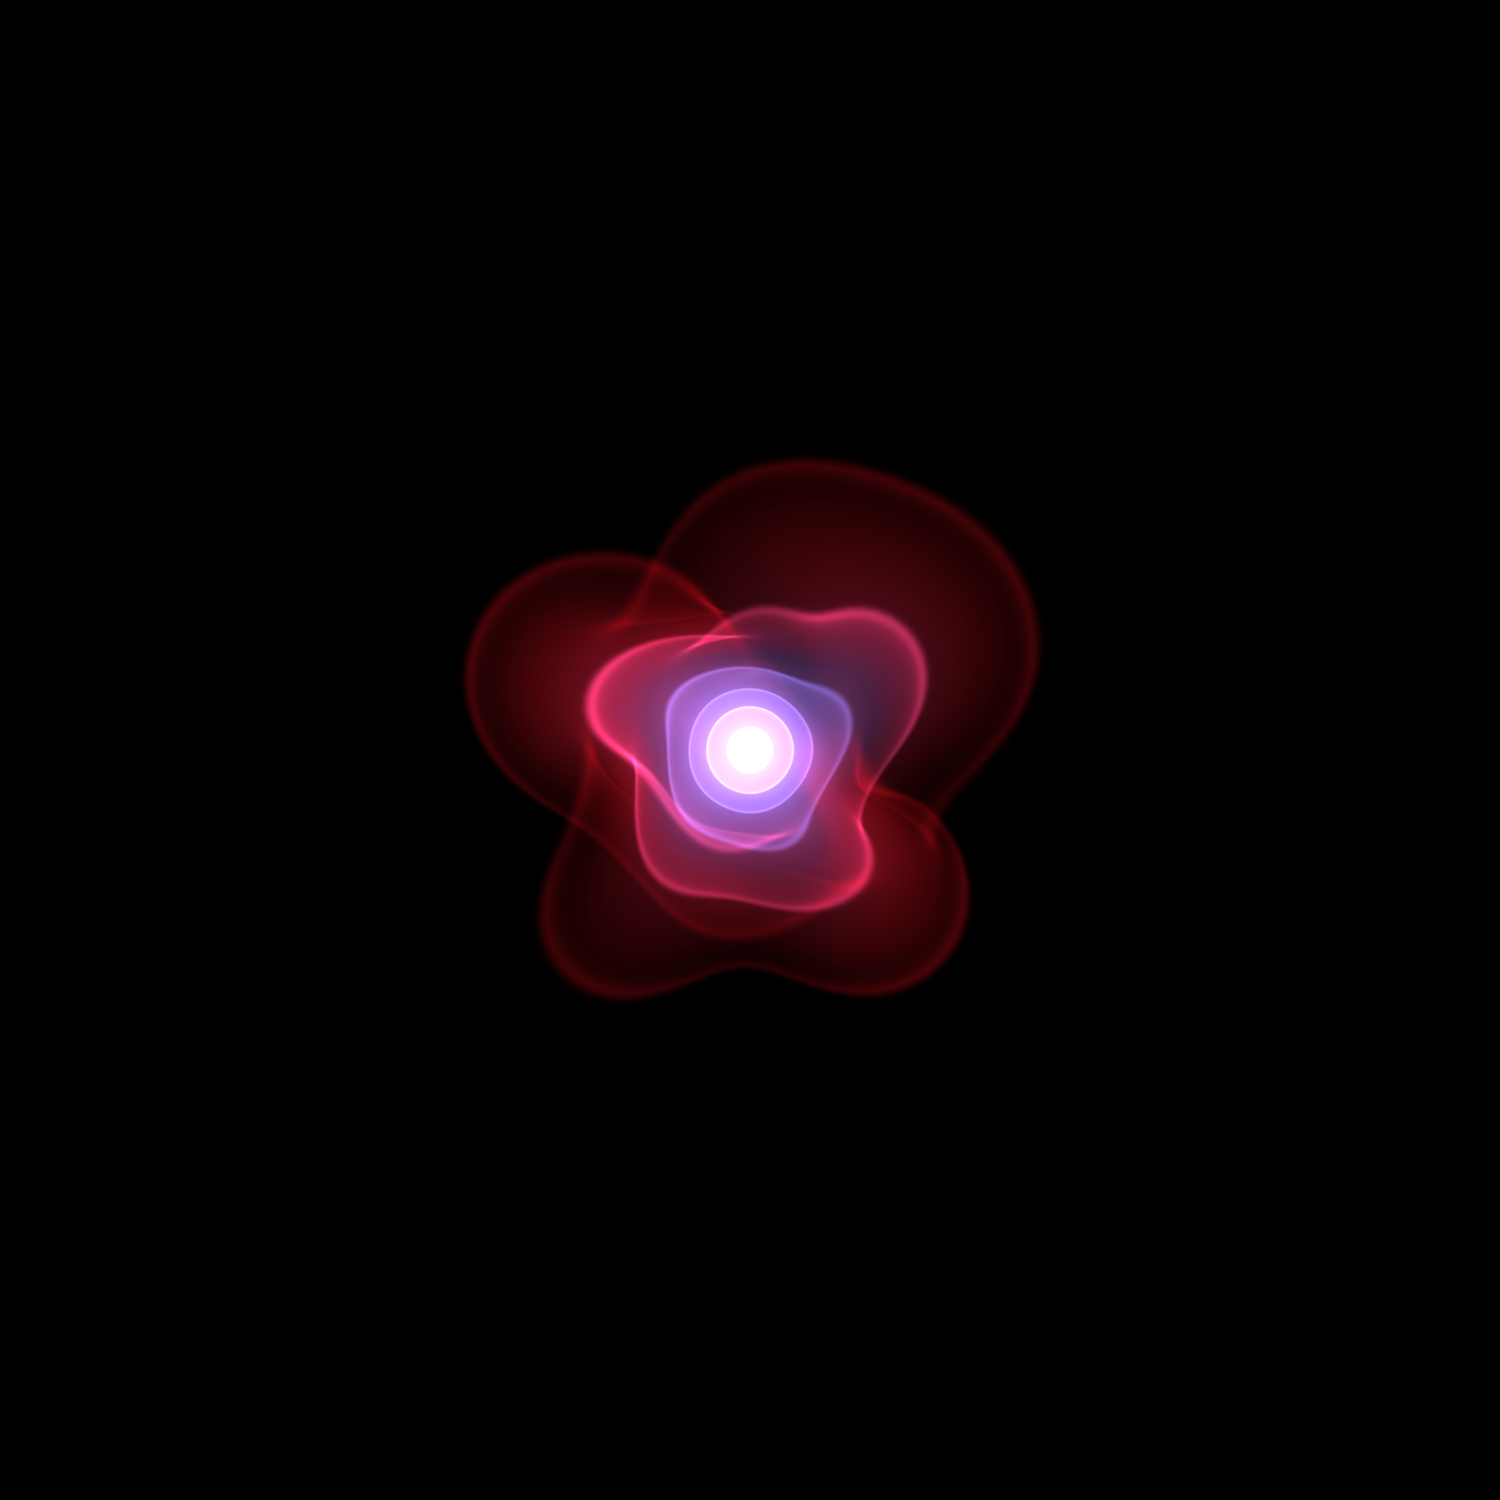

yt : [WARNING  ] 2024-05-14 12:28:20,954 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rendered image directly.
yt : [INFO     ] 2024-05-14 12:28:20,955 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-14 12:29:01,633 Saving rendered image to leoII_0022.png


In [25]:
psi2_xyz = np.load("psi2_22.npy") * u.to_Msun/u.to_Kpc**3
sc = yt.create_scene(ds.sphere(ds.domain_center,((0.9*R * u.to_Kpc).item(),"kpc")), ("stream", "density"), "perspective")
source = sc.get_source()
source.set_log(True)
bounds=(2.5e3,2e9)

tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=False)

def quadramp(vals, minval, maxval):
    return ((vals - vals.min()) / (vals.max() - vals.min()))**.5

tf.map_to_colormap(
    np.log10(bounds[0]), np.log10(bounds[1]), 
    colormap="gist_stern", 
    scale_func=quadramp
)
tf.add_layers(8,
              colormap="gist_stern", 
              alpha=np.geomspace(1, 6, 8))

source.tfh.tf = tf
source.tfh.bounds = bounds

camera = sc.camera
camera.position = [1.,1.,1.]
camera.resolution = (1500,1500)
camera.zoom(1.4)

camera.switch_orientation()
sc.show(sigma_clip=3.)
sc.save("leoII_0022.png", sigma_clip=3.0)


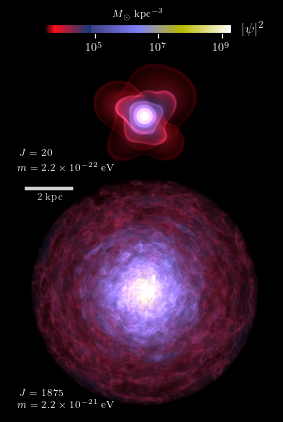

In [26]:
image = plt.imread("leoII_0022.png")
fig, ax = plt.subplots(figsize=(figwidth, 1.7*figwidth), nrows=2, sharex=True, sharey=True)
fig.set_facecolor("k")
ax[0].axis('off')
ax[0].grid(False)
ax[1].axis('off')
ax[1].grid(False)
ax[0].imshow(image[270:-400,:-30])

ax[0].text(0.025, 0.44, r"$m=2.2\times10^{-22}\mathrm{\;eV}$", transform=ax[0].transAxes,  ha="left", c="white", va="top", fontsize=7)
ax[0].text(0.0358, 0.49, rf"$J={lib_dict[2.2].J}$", transform=ax[0].transAxes,  ha="left", c="white", va="top", fontsize=7)
#ax.text(0.03, 0.93, rf"$M_\mathrm{{tot}}={latex_float(jsp.total_mass(density_params) * u.to_Msun)}M_\odot$", transform=ax.transAxes,  ha="left", va="top", c="white", fontsize=15)

image = plt.imread("leoII_0220.png")
ax[1].imshow(image[120:-80,:-30])
ax[1].text(0.025, 0.06, r"$m=2.2\times10^{-21}\mathrm{\;eV}$", transform=ax[1].transAxes,  ha="left", c="white", va="top", fontsize=7)
ax[1].text(0.0358, 0.10, rf"$J={lib_dict[22].J}$", transform=ax[1].transAxes,  ha="left", c="white", va="top", fontsize=7)

cmap = mpl.colormaps['gist_stern'].copy()
norm = mpl.colors.LogNorm(vmin=bounds[0], vmax=bounds[1])
cax = fig.add_axes([0.225,0.82,0.55,.016])

cax.xaxis.tick_top()
cax.xaxis.label.set_color('white')
cax.tick_params(axis='x', colors='white')

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation="horizontal",
                  cax=cax)
cb.ax.xaxis.label.set_color("white")
cb.set_label(label=r"$M_\odot\;\mathrm{kpc}^{-3}$", fontsize=7)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(7)

cax.xaxis.set_label_position('top') 
ax[0].text(0.88, 0.99, r"$|\psi|^2$", transform=ax[0].transAxes,  ha="left", c="white", fontsize=10)
cax.grid(False)

ax[1].text(0.15, 0.92, r"$2\;\mathrm{kpc}$", transform=ax[1].transAxes,  
           ha="center", c="lightgray", va="center", fontsize=7)

plt.subplots_adjust(wspace=0, hspace=-0.5)
ax[1].plot([90,90+250],[50,50], c="lightgray", lw=2.5)
plt.xticks(fontsize=8)
plt.show()

### Figure 3 (Hypothesis Test)

In [27]:
mass = []
mmd = {}
mmds = []
m22 = [15, 19, 20, 21, 22, 23, 24]
tag = []
for i,m in enumerate(m22):
    cache = f"../data/hypothesis_test/"
    data = jnp.load(f"{cache}/leoii_{m}.npz")
    mmd[m] = data["mmd"]
    mmds.append(data["mmds"][:-1])
    mass.append(m * jnp.ones_like(mmds[-1]))
    tag.append(i * jnp.ones_like(mmds[-1]))
df = pd.DataFrame.from_dict({
        "mass": jnp.concatenate(mass), 
        "mmd": jnp.concatenate(mmds),
        "tag": jnp.concatenate(tag)
    }
)
for m in m22:
    min_m = df[df["mass"] == m]["mmd"].min()
    df.loc[df["mass"] == m, "mmd"] -= min_m
    df.loc[df["mass"] == m, "mmd"] += 2e-3
    mmd[m] -= min_m
    mmd[m] += 2e-3

1.0
0.99985
0.997
0.9932
0.9666
0.89665
0.73905


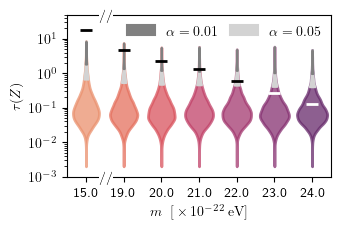

In [28]:
fig, ax = plt.subplots(figsize=(figwidth, 0.618*figwidth), )

ax = sns.violinplot(data=df, x="mass", y="mmd", hue=True,
               log_scale=True, 
               legend=False,
               linewidth=2, 
               #split=True,
               #hue_order=[True,False],
               cut=0,
               ax=ax,
               inner=None,
               alpha=0.75,
               #native_scale=True,
               palette="flare")

heights = [2e3, 2e3, 1e2, 1e2]
pvals = []
for i, (m, violin) in enumerate(zip(m22, ax.findobj(PolyCollection))):
    points = violin.get_paths()[0].vertices
    violin.set_edgecolor(sns.color_palette("flare", n_colors=7)[i] + (1,))
    violin.set_facecolor(sns.color_palette("flare", n_colors=7)[i] + (1,))

    x = points[:, 0]
    y = points[:, 1]
    df_m = df[df["mass"] == m]

    p = (df_m >= mmd[m]).mean()
    pvals.append(p.iloc[1])
    print(1 - p.iloc[1])
    CL = [0.95, 0.99]
    color = ["lightgray", "gray"]
    for j, cl in enumerate(CL):
        percentile = df_m.quantile(cl).iloc[1]
        if i==len(m22)-1:
        
            ax.fill_between(
                x[y>percentile],
                y[y>percentile],
                y2=percentile, 
                color=color[j], 
                #edgecolor="dimgray",
                lw=1.5,
                label=fr"$\alpha={1-cl:.2f}$"
            )
        else:
            ax.fill_between(
                x[y>percentile],
                y[y>percentile],
                y2=percentile, 
                color=color[j],
                #edgecolor="dimgray",
                lw=1.5
            )

    #ax.text(i,heights[i], f"$p={latex_float(p['mmd'])}$", ha="center", va="bottom", fontsize=10)

color = ["k","k","k","k","k","w","w","w"]
for i,m in enumerate(mmd):
    if m==1:
        ax.scatter(i, mmd[m], color=color[i], marker="_", label=r"$\texttt{mmd_fuse}\left(\{\rho\}, \{|\psi|^2\}\right)$")
    else:
        ax.scatter(i, mmd[m], color=color[i], marker="_", s=70)

l,h = ax.get_legend_handles_labels()
l[0], l[1] = l[1], l[0]
h[0], h[1] = h[1], h[0]
ax.legend(l,h, loc="lower left", ncols=2, bbox_to_anchor=[0.18,0.78], columnspacing=0.9)
ax.set_xlabel(r"$m\;\;\mathrm{[}\times 10^{-22}\mathrm{\; eV]}$")
ax.text(0.12, -0.031, r"$//$", transform=ax.transAxes, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
ax.text(0.12, 1-0.031, r"$//$", transform=ax.transAxes, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

ax.set_ylabel(r"$\tau(Z)$")
ax.set_ylim([1e-3, 5e1])
ax.set_xlim([-0.5,6.5])
plt.show()

### Figure 4 (Limits)

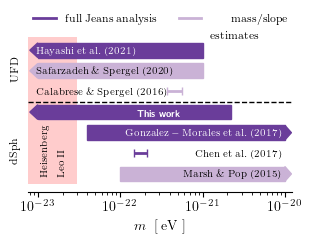

In [29]:
from mpl_toolkits.axisartist.axislines import SubplotZero

colors = sns.color_palette("Paired",10)
limits_dsph = {
    "marsh_pop": {
        "type": "simplified",
        "limit": (1e-22,1e-20),
        "author": r"$\mathrm{Marsh\;\&\;Pop}\;(2015)$",
        "label":"k"
    },
    "chen": {
        "type": "jeans",
        "limit": ((1.79-0.33)*1e-22, (1.79+0.35)*1e-22),
        "author": r"$\mathrm{Chen\;et\;al.}\;(2017)$",
        "label":"k"
    },
    "gonzalez": {
        "type": "jeans",
        "limit": (4e-23,1e-20),
        "author": r"$\mathrm{Gonzalez-Morales\;et\;al.}\;(2017)$",
        "label":"w"
    },
    "zimmermann": {
        "type": "jeans",
        "limit": (1e-23,2.2e-21),
        "author": r"$\mathrm{\textbf{This\;work\qquad\qquad\qquad\qquad\quad3}}$",
        "label":"w"
    }
}
limits_ufd = {
    "calabrese": {
        "type": "simplified",
        "limit": (3.7*1e-22, 5.6*1e-22),
        "author": r"$\mathrm{Calabrese\;\&\;Spergel}\;(2016)$",
        "label":"k"
    },
    "Safarzadeh": {
        "type": "simplified",
        "limit": (1e-23,1e-21),
        "author": r"$\mathrm{Safarzadeh\;\&\;Spergel}\;(2020)$",
        "label":"k"
    },
    "hayashi": {
        "type": "jeans",
        "limit": (1e-23,1e-21),
        "author": r"$\mathrm{Hayashi\;et\;al.}\;(2021)$",
        "label":"w"
    }
}

type_to_color = {
    "jeans": colors[9],
    "simplified": colors[8]
    
}

fig, ax = plt.subplots(figsize=(figwidth,0.618*figwidth))
ax.set_xscale("log")
xmin = 1e-23
xmax = 1e-20
ax.set_xlim([0.77*xmin, 1.23*xmax])
ax.fill_between([0.77*xmin, 3e-23],1,color="red", alpha=0.2, edgecolor="None")
ax.text(1.5e-23,0.045, r"$\mathrm{Heisenberg}\\\mathrm{\qquad Leo\;II}$", ha="center", va="bottom", color="k", fontsize=7, rotation=90)
hspace = 0.02
bar_height = 0.1
for i,limit in enumerate(limits_dsph.values()):
    type, l, author,label = [item for item in limit.values()]
    if l[0] > xmin and l[1]<xmax:
        ax.errorbar(0.5*(l[1] + l[0]), (2*i+1)*hspace+bar_height*i + bar_height/2, xerr=0.5*(l[1] + l[0]) - l[0], 
                    capsize=3,
                    color=type_to_color[type])
    else:
        rect = mpl.patches.Rectangle((l[0],(2*i+1)*hspace+bar_height*i),l[1] -l[0], bar_height, 
                                 color=type_to_color[type])
        ax.add_patch(rect)
    if l[0] == xmin:
        path = [
            [xmin, (2*i+1)*hspace+bar_height*i],
            [xmin, (2*i+1)*hspace+bar_height*i + bar_height],
            [0.8*xmin, (2*i+1)*hspace+bar_height*i + 0.5 * bar_height],
        ]
        ax.add_patch(mpl.patches.Polygon(path, color=type_to_color[type]))
    if l[1] == xmax:
        path = [
            [xmax, (2*i+1)*hspace+bar_height*i],
            [xmax, (2*i+1)*hspace+bar_height*i + bar_height],
            [1.2*xmax, (2*i+1)*hspace+bar_height*i + 0.5 * bar_height],
        ]
        ax.add_patch(mpl.patches.Polygon(path, color=type_to_color[type]))
    ax.text(9e-21, (2*i+1)*hspace+bar_height*i+0.01, author, ha="right", va="bottom", color=label, fontsize=7)
i += 1
ax.axhline(y=(2*i)*hspace+bar_height*i, ls="dashed", color="black", lw=1)
for j,limit in enumerate(limits_ufd.values()):
    k = i+j
    type, l, author,label = [item for item in limit.values()]
    if l[0] > xmin and l[1]<xmax:
        ax.errorbar(0.5*(l[1] + l[0]), (2*k+1)*hspace+bar_height*k + bar_height/2, xerr=0.5*(l[1] + l[0]) - l[0], 
                    capsize=3,
                    color=type_to_color[type])
    else:
        rect = mpl.patches.Rectangle((l[0],(2*k+1)*hspace+bar_height*k),l[1] -l[0], 
                                 bar_height, 
                                 color=type_to_color[type])
        ax.add_patch(rect)
    if l[0] == xmin:
        path = [
            [xmin, (2*k+1)*hspace+bar_height*k],
            [xmin, (2*k+1)*hspace+bar_height*k + bar_height],
            [0.8*xmin, (2*k+1)*hspace+bar_height*k + 0.5 * bar_height],
        ]
        ax.add_patch(mpl.patches.Polygon(path, color=type_to_color[type]))
    ax.text(9.4e-24, (2*k+1)*hspace+bar_height*k+0.01, author, ha="left", va="bottom", color=label, fontsize=7)
ax.text(-0.07,0.25, r"$\mathrm{dSph}$", rotation=90, transform=ax.transAxes, va="center", fontsize=8)
ax.text(-0.07,0.75, r"$\mathrm{UFD}$", rotation=90, transform=ax.transAxes, va="center", fontsize=8)

ax.spines[['right', 'top', "left"]].set_visible(False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_yticks([])
ax.set_xlabel(r"$m\;\;\mathrm{[\;eV\;]}$")
ax.plot([1],[1], c=colors[9], label=r"$\mathrm{full\;Jeans\;analysis}$")
ax.plot([1],[1], c=colors[8], label=r"$\mathrm{mass/slope}\\\mathrm{estimates}$")
ax.legend(*ax.get_legend_handles_labels(), bbox_to_anchor=(0,0.92,1,0.2), ncols=2, loc="center", fontsize=8)

plt.show()